In [3]:
import sys
sys.path.append('./detr/')
from glob import glob
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import albumentations as A
from detr.models.detr import SetCriterion
from detr.models.matcher import HungarianMatcher
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm
import torch

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from sklearn.model_selection import StratifiedKFold
import cv2
from collections import Iterable


n_folds = 5
seed = 42
num_classes = 10
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 2
LR = 2e-5
EPOCHS = 1

ImageDf = pd.read_csv('./testing_read_data/ImageID.csv')
pathTrainingData = "../datasets/train/data/"


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1, 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']




C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21244\846500505.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class Detr(nn.Module):
    def __init__(self,num_classes,num_queries,backbone='detr_resnet50'):
        super(Detr, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr:main', backbone, pretrained=True)
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(self.in_features, self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,image):
        return self.model(image)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import pandas as pd
import cv2
import os
import json



classes = {"car":0,"motorbike":1,"riksha":2,"auto":3,"minitruck":4,"van":5,"bus":6,"truck":7,"bicycle":8}

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(height=512, width=512, p=1),
    ToTensorV2(p=1),
],
    p=1.0,
    bbox_params=A.BboxParams(format='coco',  label_fields=['labels'])
)


validTransform = A.Compose([
                    A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )
                      


class VehicleDetectionDataset(Dataset):
    def __init__(self, ImageDf, annotation, path, transform=None):
        super(VehicleDetectionDataset, self).__init__()
        self.ImageDf = ImageDf
        self.transform = transform
        self.annotation = annotation
        self.path = path

    def __len__(self):
        return len(self.ImageDf)

    def __getitem__(self, index):
        self.imgName = self.ImageDf['id'][index]
        imgNameXml = self.imgName.split('.')
        imgNameXml[-1] = "xml"
        imgNameXml = '.'.join(imgNameXml)
        self.imgNameXml = imgNameXml
        self.imgFolder = self.ImageDf['folders'][index]
        self.imgPath = os.path.join(self.path, self.imgFolder, self.imgName)
        img = cv2.imread(self.imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = img/255.0
        imgMetaData = self.annotation[self.imgNameXml]
        labels = []
        bboxes = []
        for data in range(len(imgMetaData[0])):
            labels.append(classes[imgMetaData[0][data][0]])
            bboxes.append(imgMetaData[0][data][1:])

        area = [x[2]*x[3] for x in bboxes]
        area = torch.as_tensor(area, dtype=torch.float32)


        sample = {'image': img, 'labels': labels, 'bboxes': bboxes}
        if self.transform:
            sample = self.transform(**sample)

        _,h,w = sample['image'].shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return sample['image'], target,index


ImageDf = pd.read_csv('./testing_read_data/ImageID.csv')
#remove_list = [602,640,677,681,727,760,7880,8039,8085]
#ImageDf.drop(ImageDf['id'].index[remove_list], inplace=True)
path = "../datasets/train/data/"
pathTest = "../datasets/test/data/"
TestDf = pd.read_csv('./testing_read_data/TestImageID.csv')
#remove_list_val = [216,246,276]
#TestDf.drop(TestDf['id'].index[remove_list_val], inplace=True)
### loading data code ########

# with open('testing_read_data/annotation.json') as f:
#     annotation = json.load(f)
#     dataset = VehicleDetectionDataset(ImageDf, annotation, path,transform=transform)
#     print(dataset[55])











In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))


def train_fn(data_loader,size, model, criterion, optimizer, device, scheduler, epoch):
    print("entered training function")
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    trainIter = iter(data_loader)
    for i in range(size):
        #print(f"{i}th data in epoch")   
        try:
            images, targets, image_ids = next(trainIter)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            #print("feed to the model")
            output = model(images)
            #print("model output computed")

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k]
                        for k in loss_dict.keys() if k in weight_dict)

            optimizer.zero_grad()

            losses.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            summary_loss.update(losses.item(), BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

        except Exception as e:
            print(e)
            pass
    
    # for step, (images, targets, image_ids) in enumerate(tk0):
    #     try:
    #        # print("training loop started ")
    #         images = list(image.to(device) for image in images)
    #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #         #print("feed to the model")
    #         output = model(images)
    #         #print("model output computed")

    #         loss_dict = criterion(output, targets)
    #         weight_dict = criterion.weight_dict

    #         losses = sum(loss_dict[k] * weight_dict[k]
    #                     for k in loss_dict.keys() if k in weight_dict)

    #         optimizer.zero_grad()

    #         losses.backward()
    #         optimizer.step()
    #         if scheduler is not None:
    #             scheduler.step()

    #         summary_loss.update(losses.item(), BATCH_SIZE)
    #         tk0.set_postfix(loss=summary_loss.avg)
    #     except Exception as e:
    #         print(e)
    return summary_loss

def eval_fn(data_loader,size, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))

        valIter = iter(data_loader)
        for i in range(size):
            #print(f"{i}th validation data in epoch")
            try:
                images, targets, image_ids = next(valIter)
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                output = model(images)
            
                loss_dict = criterion(output, targets)
                weight_dict = criterion.weight_dict
            
                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                
                summary_loss.update(losses.item(),BATCH_SIZE)
                tk0.set_postfix(loss=summary_loss.avg)
                

            except Exception as e:
                print(e)
                pass

        # try:
        #     for step, (images, targets, image_ids) in enumerate(tk0):
        #         images = list(image.to(device) for image in images)
        #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #         output = model(images)
            
        #         loss_dict = criterion(output, targets)
        #         weight_dict = criterion.weight_dict
            
        #         losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                
        #         summary_loss.update(losses.item(),BATCH_SIZE)
        #         tk0.set_postfix(loss=summary_loss.avg)
                

        # except Exception as e:
        #     print(e)
        #     pass    
    return summary_loss


def run(fold):

    with open('testing_read_data/annotation.json') as f0, open('testing_read_data/annotationTest.json') as f1:
        annotation = json.load(f0)
        testAnotation = json.load(f1)
        train_dataset = VehicleDetectionDataset(
            ImageDf, annotation, path, transform=transform)
        loaderSize = len(train_dataset)
        
        valid_dataset = VehicleDetectionDataset(
            TestDf, testAnotation, pathTest, transform=validTransform
        )
        valLoaderSize = len(valid_dataset)

        #print("train dataset length", len(train_dataset))
       # print(type(train_dataset[0][0]))

        train_data_loader = DataLoader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       collate_fn=collate_fn
                                       )
        #print("DataSet loader loaded")
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

    device = torch.device('cuda')
    model = Detr(num_classes=num_classes, num_queries=num_queries)

    #print("model loaded ")
    model = model.to(device)

    #print("model to  device")

    criterion = SetCriterion(
        num_classes-1, matcher, weight_dict, eos_coef=null_class_coef, losses=losses)
    criterion = criterion.to(device)

    #print("criterion to  device")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    best_loss = 10**5
    for epoch in range(EPOCHS):
        print("epoch", epoch)
        train_loss = train_fn(train_data_loader,loaderSize, model, criterion,
                              optimizer, device, scheduler=None, epoch=epoch)

        print("exited train fn")
        valid_loss = eval_fn(valid_data_loader,valLoaderSize, model, criterion, device)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(
            epoch+1, train_loss.avg, valid_loss.avg))
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(
            epoch+1, train_loss.avg, -1))
        torch.save(model.state_dict(), f'detr_best_{fold}.pth')

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(
                fold, epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')


In [ ]:
run(0)




In [ ]:
with open('testing_read_data/annotation.json') as f0, open('testing_read_data/annotationTest.json') as f1:
        annotation = json.load(f0)
        testAnotation = json.load(f1)
        train_dataset = VehicleDetectionDataset(
            ImageDf, annotation, path, transform=transform)
        train_data_loader = DataLoader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       collate_fn=collate_fn
                                       )
size = len(train_dataset)
trainIter = iter(train_data_loader)
for i in range(size):
    try:
        images, targets, image_ids = next(trainIter)
    except Exception as e:
        print(e)
        pass

In [ ]:
with open('testing_read_data/annotation.json') as f0, open('testing_read_data/annotationTest.json') as f1:
        annotation = json.load(f0)
        testAnotation = json.load(f1)
        # train_dataset = VehicleDetectionDataset(
        #     ImageDf, annotation, path, transform=transform2)

        valid_dataset = VehicleDetectionDataset(
            TestDf, testAnotation, pathTest, transform=validTransform
        )
        train_data_loader = DataLoader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       collate_fn=collate_fn
                                       )

for i in range(0, len(valid_dataset)):
    try:
        valid_dataset[i]
    except Exception as e:
        c += 1
        print(i)
valid_dataset[216]

In [ ]:
with open('testing_read_data/annotation.json') as f0, open('testing_read_data/annotationTest.json') as f1:
        annotation = json.load(f0)
        testAnotation = json.load(f1)
        train_dataset = VehicleDetectionDataset(
            ImageDf, annotation, path, transform=transform)

        train_data_loader = DataLoader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       collate_fn=collate_fn
                                       )


In [ ]:
ImageDf = ImageDf.drop[ImageDf.index[remove_list]]

In [6]:
from PIL import Image
model = Detr(num_classes=10, num_queries=num_queries)
model.load_state_dict(torch.load('./detr_best_0.pth'))
model.eval()
device = torch.device('cuda')
    #print("model loaded ")
#model = model.to(device)
import torchvision.transforms as T
transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
im = cv2.imread("./2.jpg")
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
im = Image.fromarray(im)
#im = cv2.resize(im, (512,512))
img = transform(im).unsqueeze(0)
#img = img.to(device)

Using cache found in C:\Users\LENOVO/.cache\torch\hub\facebookresearch_detr_main


In [7]:
outputs = model(img)

C:\Users\LENOVO/.cache\torch\hub\facebookresearch_detr_main\models\position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [8]:
outputs

{'pred_logits': tensor([[[ 4.0266e-02, -9.8839e+00, -1.0204e+01, -9.9653e+00, -1.0949e+01,
           -1.0171e+01, -1.0644e+01, -1.0127e+01, -1.1394e+01,  5.2014e+00],
          [-1.4170e-01, -1.0467e+01, -1.0842e+01, -1.0531e+01, -1.1625e+01,
           -1.0695e+01, -1.1343e+01, -1.0525e+01, -1.2011e+01,  4.2913e+00],
          [-2.3122e-02, -1.0382e+01, -1.0809e+01, -1.0505e+01, -1.1273e+01,
           -1.0481e+01, -1.1342e+01, -1.0601e+01, -1.1819e+01,  4.5930e+00],
          [-9.6294e-01, -1.0119e+01, -1.0524e+01, -9.4959e+00, -1.0642e+01,
           -9.8109e+00, -1.1259e+01, -1.0355e+01, -1.1436e+01,  4.1016e+00],
          [ 2.2392e-01, -1.0491e+01, -1.0875e+01, -1.0398e+01, -1.1455e+01,
           -1.0485e+01, -1.1512e+01, -1.0619e+01, -1.1855e+01,  3.6757e+00],
          [ 1.7715e+00, -1.0116e+01, -1.0363e+01, -1.0254e+01, -1.1609e+01,
           -1.0583e+01, -1.1258e+01, -1.0493e+01, -1.1702e+01,  4.1431e+00],
          [ 3.1122e-02, -1.0304e+01, -1.1078e+01, -1.0501e+01, -1.1

In [9]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox,size):
    img_w, img_h = size
    #b = box_cxcywh_to_xyxy(out_bbox)
    x_min, y_min, w, h = out_bbox.unbind(1)
    b = [x_min, y_min, x_min+w, y_min+h]
    b = torch.stack(b, dim=1)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
    
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)


In [10]:
bboxes_scaled

tensor([[  0.9656,   5.5529, 108.8395, 174.7911],
        [150.0457,   5.1285, 260.2308, 191.0682]], grad_fn=<MulBackward0>)

In [15]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

          
classes = {"car":0,"motorbike":1,"riksha":2,"auto":3,"minitruck":4,"van":5,"bus":6,"truck":7,"bicycle":8}
CLASSES = [
    "car","motorbike","riksha","auto","minitruck","van","bus","truck","bicycle"
]          
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.savefig('testplot.png')
    plt.axis('off')
    plt.show()


    

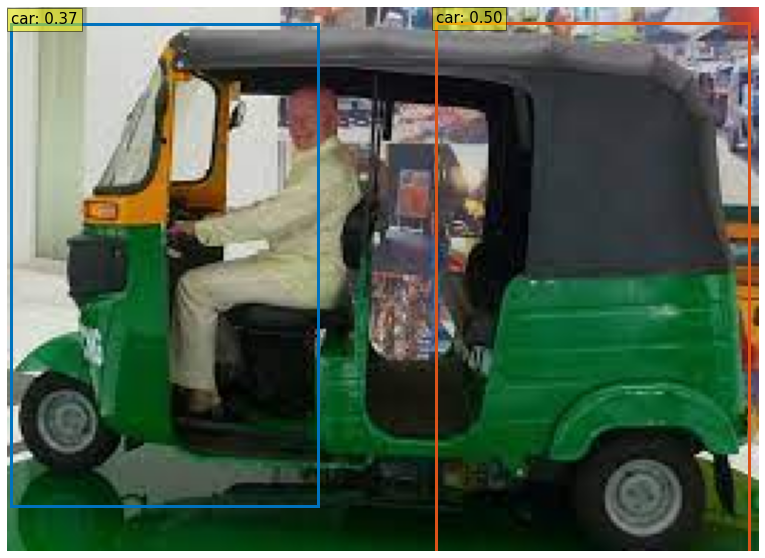

In [16]:
plot_results(im, probas[keep], bboxes_scaled)

True